### We're going to be building and training a deep Q-network to learn to balance a pole on a moving cart.

The cart and pole problem consists of a cart that can move left and right along a frictionless track. The cart has a pole attached to the top of it, which starts out in a vertical upright position, however, by design, the pole will fall either to the left or right when not balanced. The goal here is to prevent this pole from falling over. A reward of +1 will be given for each time step that the pole remains upright, and an episode will deemed over when the pole is more than 15 degrees from vertical or when the cart moves more than 2.4 units from the center of the screen. 
#### So, essentially, the longer the pole remains upright without deviating too far from the center of the screen, the more reward our agent will get. 

###### what would happen with no optimization for this cart and pole problem?
below is a quick snippet of code that will run an instance of the cart and pole environment from Gym for 1000 time steps and will take a random action, either left or right, at each time step. We'll render the environment at each step so we can see what this will look like. 

In [1]:
# import gym

# env = gym.make('CartPole-v0')
# env.reset()

# for _ in range(1000):
#     env.render()
#     env.step(env.action_space.sample())
# env.close()

our deep Q-network will definitely have some learning to do so that it can balance the pole better than this! 

In [2]:
# conda install pytorch-cpu torchvision-cpu -c pytorch

### DQN training process

1. Initialize replay memory capacity.

2. Initialize the policy network with random weights.

3. Clone the policy network, and call it the target network.

4. For each episode:
    1.Initialize the starting state.
    2.For each time step:
        1.Select an action.
            - Via exploration or exploitation
        2.Execute selected action in an emulator.
        3.Observe reward and next state.
        4.Store experience in replay memory.
        5.Sample random batch from replay memory.
        6.Preprocess states from batch.
        7.Pass batch of preprocessed states to policy network.
        8.Calculate loss between output Q-values and target 
          Q-values. Requires a pass to the target network for the 
          next state
        9.Gradient descent updates weights in the policy 
          network to minimize loss.After x time steps, weights 
          in the target network are updated to the weights in 
          the policy network.

In [3]:
import torch
torch.__version__

'1.1.0'

Import libraries 

In [4]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn               # Νeural networks (torch.nn)
import torch.optim as optim         # Οptimization (torch.optim)
import torch.nn.functional as F 
import torchvision.transforms as T    

Set up Display

In [5]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

### Deep Q-network 

Q-values that correspond to each possible action that the agent can take from a given state. Our only available actions are to move right or to move left, therefore, the number outputs will be equal to two. 

Also, note that this network is pretty arbitrary and also very basic. It doesn't even contain any convolutional layers. I wanted to start out with something very straight forward at first, and then once we see how this network performs, we can start tuning the architecture and experimenting with different variations. 

In [6]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()

        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
        
    #This function will implement a forward pass to the networ
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

### Experience 

Experiences from replay memory is what we'll use to train our network. To create experiences, we creating a class called Experience. This class will be used to create instances of Experience objects that will get stored in and sampled from replay memory later. 

In [7]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [8]:
# quick example of an Experience object. 
e = Experience(2,3,1,4)   
e

Experience(state=2, action=3, next_state=1, reward=4)

### Replay Memory 
Now that we have our Experience class, let's define our ReplayMemory class, which is where these experiences will be stored.

Recall that replay memory will have some set capacity. This capacity is the only parameter that needs to be specified when creating a ReplayMemory object. 

In [9]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1 
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

##### push() : 
accepts experience, and when we want to push a new experience into replay memory, we have to check first that the amount of experiences we already have in memory is indeed less than the memory capacity. If it is, then we append the experience to memory.

If, on the other hand, the amount of experiences we have in memory has reached capacity, then we begin to push new experiences onto the front of memory, overwriting the oldest experiences first.

##### sample() : 
Aside from storing experiences in replay memory, we also want to be able to sample experiences from replay memory. Remember, these sampled experiences will be what we use to train our DQN. We define this sample() function, which returns a random sample of experiences. The number of randomly sampled experiences returned will be equal to the batch_size parameter passed to the function. 

###  Epsilon Greedy Strategy 
Exploration versus exploitation.This has to do with the way our agent selects actions. Our agent's actions will either fall in the category of exploration, where the agent is just exploring the environment by taking a random action from a given state, or the category of exploitation, where the agent exploits what it's learned about the environment to take the best action from a given state. 

To get a balance of exploration and exploitation, we use what we previously introduced as an epsilon greedy strategy. With this strategy, we define an exploration rate called epsilon that we initially set to 1 . This exploration rate is the probability that our agent will explore the environment rather than exploit it. With epsilon equal to 1 , it is 100 percent certain that the agent will start out by exploring the environment.

As the agent learns more about the environment, though, epsilon will decay by some decay rate that we set so that the likelihood of exploration becomes less and less probable as the agent learns more and more about the environment.

Our agent is going to be able to use the exploration rate to determine how it should select it's actions, either by exploring or exploiting the environment. 

In [10]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
        math.exp(-1. * current_step * self.decay)

### Reinforcement Learning Agent 

So, later when we create an Agent object, we'll need to already have an instance of EpsilonGreedyStrategy class created so that we can use that strategy to create our agent. num_actions corresponds to how many possible actions can the agent take from a given state. In our cart and pole example, this number will always be two since the agent can always choose to only move left or right. 

Policy network is the name we give to our deep Q-network that we train to learn the optimal policy.

Within this function, we first initialize rate to be equal to the exploration rate returned from the epsilon greedy strategy that was passed in when we created our agent, and we increment the agent's current_step by 1.

We then check to see if the exploration rate is greater than a randomly generated number between 0 and 1. If it is, then we explore the environment by randomly selecting an action, either 0 or 1, corresponding to left or right moves.

If the exploration rate is not greater than the random number, then we exploit the environment by selecting the action that corresponds to the highest Q-value output from our policy network for the given state.

We're specifying with torch.no_grad() before we pass data to our policy_net to turn off gradient tracking since we're currently using the model for inference and not training.

During training PyTorch keeps track of all the forward pass calculations that happen within the network. It needs to do this so that it can know how to apply backpropagation later. Since we're only using the model for inference at the moment, we're telling PyTorch not to keep track of any forward pass calculations. 

In [11]:
# class Agent():
#     def __init__(self, strategy, num_actions, device):
#         self.current_step = 0
#         self.strategy = strategy
#         self.num_actions = num_actions
#         self.device = device
    
#     def select_action(self, state, policy_net):
#         rate = self.strategy.get_exploration_rate(self.current_step)
#         self.current_step += 1

#         if rate > random.random():
#             return random.randrange(self.num_actions) # explore      
#         else:
#             with torch.no_grad():
#                 return policy_net(state).argmax(dim=1).to(self.device) # exploit

class Agent():
    def __init__(self, strategy, num_actions,device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device= device
    
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

## Environment Manager 
This class will manage our cart and pole environment. It will wrap several of gym's environment capabilities, and it will also give us some added functionality, like image preprocessing, for the environment images that will be given to our network as input. 

###### __init__ :
Within the class constructor, we first initialize the class's device attribute with the device that was passed in, and we initialize the env attribute to be gym's cart and pole environment. Calling unwrapped gives us access to behind-the-scenes dynamics of the environment that we wouldn't have access to otherwise.

Since we must reset the environment to get an initial observation of it, we do this right after initializing env. We then set the current_screen attribute equal to None. current_screen will track the current screen of the environment at any given time, and when it's set to None, that indicates that we're at the start of an episode and have not yet rendered the screen of the initial observation.

We then set the done attribute equal to False. done will track whether or not any taken action has ended an episode. 

###### Wrapped functions : reset(), close(), and render()

We now have a few wrapper functions that simply just wrap a function with the same name used by gym. Specifically, we have reset(), close(), and render(), which reset, close, and render the environment using gym's reset(), close(), and render() functions. 

We're wrapping these functions in this way so that later, in our main program, we'll only have to deal with a CartPoleEnvManager, and not both this manager and an environment.

Instead, we're encapsulating the environment functionality within our environment manager, so that our manager can completely manage the environment using these functions, as well as new functions that an original gym environment wouldn't have access to. This gives our main program a clean and consistent interface for interacting with the environment. 

###### get_state() :
We said that states would be represented as the difference between the last two screens. Well, when we're at the start of a new episode, there is no last screen to compare to the current screen. So, we're going to represent our starting state with a fully black screen. The fact we're doing this will make more sense once we see some visual example of states in a few minutes.

When we're in the next state that occurs after an agent has taken an action that ended the episode, we'll also represent this state with a fully black screen as well.

We do this by first calling get_processed_screen(), which returns the processed screen from the environment and assigns this result to the current screen. We then create a fully black screen of the same shape as the current_screen using torch.zeros_like(). We'll explore the get_processed_screen() function more in a moment.

If we're not just starting an episode, and we're not ending it either, then we're somewhere in the middle of an episode.

In this case we'll take the difference between the current screen and the last screen and return this result.

In the code above, s1 stands for screen1 and is set to the current_screen. s2 stands for screen2 and is set to the result of a new call to get_processed_screen(). We then update our current_screen to the value of s2. So now, s2 is our current_screen, and s1 is our previous screen, so we return the difference of these two screens to represent a single state. 

###### transform_screen_data() :
This function accepts a screen. 
We first pass this screen to the numpy ascontiguousarray() function, which returns a contiguous array of the same shape and content as screen, meaning that all the values of this array will be stored sequentially next to each other in memory.

We're also converting the individual pixel values into type float32 and rescaling all the values by dividing them each by 255. This is a common rescaling process that occurs during image processing for neural network input.

We then convert this array to a PyTorch tensor.

We then use torchvision's Compose class to chain together several image transformations. We'll call this compose resize. So, when a tensor is passed to resize, it will first be converted to a PIL image, then it will be resized to a 40 x 90 image. The PIL image is then transformed to a tensor.

So, we pass our screen from above to resize and then add an extra batch dimension to the tensor by calling unsqueeze(). This result is then what is returned by the transform_screen_data() function. 

In [12]:
class CartPoleEnvManager():
    def __init__(self, device):
        
        self.device = device
        
        #we initialize the env attribute to be gym's cart and pole environment. 
        #Calling unwrapped gives us access to behind-the-scenes dynamics of the environment
        #that we wouldn't have access to otherwise. 
        self.env = gym.make('CartPole-v0').unwrapped
        
        #Since we must reset the environment to get an initial observation of it, 
        #we do this right after initializing env.
        self.env.reset()
        
        #current_screen will track the current screen of the environment at any given time, and 
        #when it's set to None, that indicates that we're at the start of an episode and have not 
        #yet rendered the screen of the initial observation. 
        self.current_screen = None
        
        #We then set the done attribute equal to False. done will track whether or not 
        #any taken action has ended an episode. 
        self.done = False
    
    #Wrapped functions
    
    # we call reset() on the gym environment when we want the environment to be reset to a starting state. 
    # reset() returns an initial observation from the environment. 
    def reset(self):
        self.env.reset()
        self.current_screen = None
    # The only one of our wrapper functions that does anything outside of calling gym's function with 
    # the same name is reset(). You can see that we're also setting the current_screen to None here. 
    # When we reset the environment, we're typically going to be at the end of an episode, and therefore, 
    # we want to set the current_screen back to None since this indicates that we're at the start of an episode 
    # and have not yet rendered the screen of the initial observation. 
    
    # We call close() to close the environment when we're finished with it
    def close(self):
        self.env.close()
    
    # we call render() on the environment to render the current state to the screen. 
    # We can also get a numpy array version of the rendered screen from this function as well. 
    def render(self, mode='human'):
        return self.env.render(mode)
    
    
    # Number of actions available to agent 
    # returns the number of actions available to an agent in the environment. In our cart and pole 
    # environment, at any given time, an agent will only have two actions available: move left or move right. 
    def num_actions_available(self):
        return self.env.action_space.n
    
    # Taking an action in the environment 
    # take_action() is a function that requires an action to be passed in. 
    # Using this action, we call step() on the environment, which will execute the given action taken 
    # by the agent in the environment. 
    # we only care about the reward and whether or not the episode ended from taking the given action, 
    # so we set the reward variable accordingly, and also update the class's done attribute with the boolean 
    # value of whether or not the episode ended by taking the given step. 
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    # Starting an episode 
    # just_starting() that returns True when the current_screen is None and returns False otherwise.
    # Remember, current_screen is set to None in the class constructor and also gets set to None when the 
    # environment is reset after ending an episode. So, if current_screen is None, that means we are at the 
    # starting state of an episode and haven't yet rendered an initial observation from the environment. 
    def just_starting(self):
        return self.current_screen is None
    
    # Getting the state of the environment 
    # The point of this function is to return the current state of the environment in the form of a 
    # processed image of the screen. Remember, a deep Q-network takes states of the environment as input, 
    # and we previously mentioned that for our environment, states would be represented using screenshot-like 
    # images. 
    
    # we will represent a single state in the environment as the difference between the current screen and the 
    # previous screen. This will allow the agent to take the velocity of the pole into account from one single 
    # image. So, a single state will be represented as a processed image of the difference between two consecutive 
    # screens.
    def get_state(self):
        # We check first to see if we are just starting or if we're done with the episode. 
        # Remember, if we're just starting, then the initial screen has not yet been rendered 
        # from the initial observation in the environment. If done == True, then that means the 
        # last action taken by the agent ended the episode. 
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        #If we're not just starting an episode, and we're not ending 
        #it either, then we're somewhere in the middle of an episode. 
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    # Get processed screen dimensions 
    # These functions return the height and width of a processed screen by first getting a processed 
    # screen from the get_processed_screen() function
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    # Processing the screen image
    # This function first renders the environment as an RGB array using the render() function and 
    # then transposes this array into the order of channels by height by width, which is what our PyTorch DQN 
    # will expect. 
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    # Crop screen image 
    # The crop_screen() function accepts a screen and will return a cropped version of it. 
    # We first get the height of the screen that was passed in, and then we strip off the top and bottom of the 
    # screen. 
    # We set top equal to the value that corresponds to 40% of the screen_height. 
    # Similarly, we set bottom equal to the value that corresponds to 80% of the screen_height. 
    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    #  Convert and rescale screen image data 
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

 #### Example screens
 
 ######  Non-processed screen 
This first screen is an example of what a non-processed screen looks like from the environment. We're getting this screen just by setting up an instance of CartPoleEnvManager, calling reset() to get an initial observation, and then rendering the screen. 

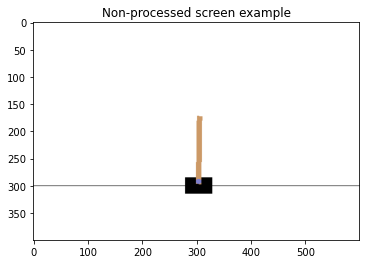

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

 ######  Processed screen 
After we do all the processing to this image simply from calling get_processed_screen(), we now get this processed image. There is actually some further processing we could do, like stripping some of the empty space from the right and left side

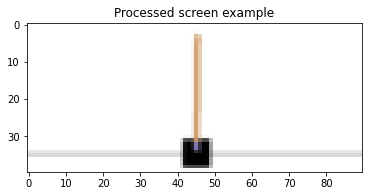

In [14]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

###### Starting state
Now, remember how a state from the environment is created from the difference between two processed images? And also how the starting state will always be a fully black screen based on our earlier discussion? Well, here we can see that example by calling get_state() on our environment manager. 

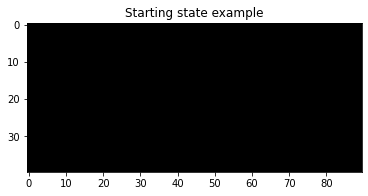

In [15]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

 ###### Non-starting state 
If we want to see what a state looks that is not a starting state, we can take some actions in the environment and call get_state() again to get this result.

Since we're taking the difference between the current screen and the previous screen, most pixel values will become zero. The only ones that are anything but zero are just the kind of highlight that we're seeing here which gives us an idea of where are cart and pole were in the previous screen, and where they have moved to now. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


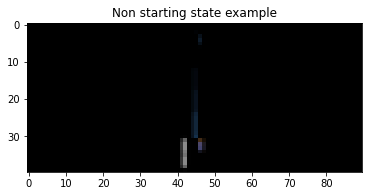

In [16]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

###### Ending state 
Lastly, if we want to see the state of the environment after an episode has ended, we specify done = True and call em.get_state() again, and we can see the fully black screen that we'd expect.

So, these states are exactly what will be passed to our DQN as input during training. 

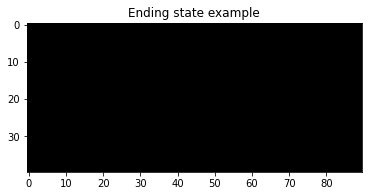

In [17]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

###### Utility functions 
Now, we're going to move on to a couple of quick utility functions we'll have available to us during training so that we can plot our performance on a chart. 

In [18]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

###### Example plot 

To show an example of this plot() function, we'll pass in a numpy array that contains 300 random values between 0 and 1, and we'll specify 100 as our moving average period. 

The actual values are plotted in blue, and the orange line is the 100-period moving average across these values.

We can see that the 100-period moving average is 0 for the first 99 values, and then we get the first calculated moving average at the 100th value. This represents the average of the first 100 values in the array. If we skip over to the moving average at value 200, then the orange line at this point represents the average of the second 100 values between value 100 to 200.

When we train our network, we'll be using this plot to show our performance over time. 

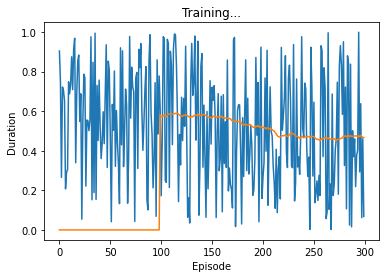

Episode 300 
 100 episode moving avg: 0.46676195


In [19]:
plot(np.random.rand(300), 100)

##  Main Program
Within our main program, we're first initializing all of our hyperparameters. 
We're first setting the batch_size for our network to 256. gamma, which is the discount factor used in the Bellman equation, is being set to 0.999.

We then have these three eps variables: eps_start, eps_end, and eps_decay.

eps_start is the starting value of epsilon. Remember, epsilon is the name we've given to the exploration rate. eps_end is the ending value of epsilon, and eps_decay is the decay rate we'll use to decay epsilon over time.

we set target_update to 10, and this is how frequently, in terms of episodes, we'll update the target network weights with the policy network weights. So, with target_update set to 10, we're choosing to update the target network every 10 episodes.

we set the memory_size, which is the capacity of the replay memory, to 100,000. We then set the learning rate lr that is used during training of the policy network to 0.001, and the number of episodes we want to play num_episodes to 1000.

In [20]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

# batch_size=2048 
# gamma=0.999 
# eps_start=1.0 
# eps_end=0.01 
# eps_decay=0.0007 
# target_update=10 
# memory_size=500000 
# lr=0.0005

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#we set up our environment manager em using the CartPoleEnvManager class, and we pass in the required device. 
#We then set our strategy to be an instance of the EpsilonGreedyStrategy class, and we pass in the required 
#start, end, and decay values for epsilon.
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
# We then define an agent using our Agent class and pass in the required strategy, number of actions available, 
# and device. We then initialize memory to be an instance of ReplayMemory and pass in the capacity using 
# memory_size.
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

# Now, we define both our policy network and target network by creating two instances of our DQN class and
# passing in the height and width of the screen to set up the appropriate input shape of the networks. We put
# these networks on our defined device using PyTorch's to() function.
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

#We then set the weights and biases in the target_net to be the same as those in the policy_net using PyTorch's
#state_dict() and load_state_dict() functions. We also put the target_net into eval mode, which tells PyTorch
#that this network is not in training mode. In other words, this network will only be used for inference.
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# we set optimizer equal to the Adam optimizer, which accepts our policy_net.parameters() as those for 
# which we'll be optimizing, and our defined learning rate lr.
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

#### Tensor Processing

In [22]:
# This is the function that we called to extract all the states, actions, rewards, and next_states 
# into their own tensors from a given batch of experiences.
# extract_tensors() accepts a batch of Experiences and first transposes it into an Experience of batches.
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    # return a tuple that contains the states tensor, actions tensor, rewards tensor, and next_states tensor.
    return (t1,t2,t3,t4)

e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

# We can see the first Experience in the list has a state, action, next_state, and reward all equal to 1. 
# The second Experience has 2 as the value of all of these attributes, and the third Experience has 3 as the 
# value for all attributes.
experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [23]:
# We can see that we now do indeed have this Experience object where the state attribute is set to 
# the tuple containing all the states from e1, e2, and e3 in the original experiences list. Similarly, 
# the action, next_state, and reward attributes contain tuples containing all the corresponding values 
# from the experiences list.
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

#### Calculating Q-Values
 This is the class that we used to calculate the q-values for the current states using the policy_net, and the next states using the target_net.

###### get_next() :
This function accepts a target_net and next_states. Recall that for each next state, we want to obtain the maximum q-value predicted by the target_net among all possible next actions.

To do that, we first look in our next_states tensor and find the locations of all the final states. If an episode is ended by a given action, then we're calling the next_state that occurs after that action was taken the final state.

Remember, last time we discussed that final states are represented with an all black screen. Therefore, all the values within the tensor that represent that final state would be zero.

We want to know where the final states are, if we even have any at all in a given batch, because we're not going to want to pass these final states to our target_net to get a predicted q-value. We know that the q-value for final states is zero because the agent is unable to receive any reward once an episode has ended.

So, we're finding the locations of these final states so that we know not to pass them to the target_net for q-value predictions when we pass our non-final next states.

To find the locations of these potential final states, we flatten the next_states tensor along dimension 1, and we check each individual next state tensor to find its maximum value. If its maximum value is equal to 0, then we know that this particular next state is a final state, and we represent that as a True within this final_state_locations tensor. next_states that are not final are represented by a False value in the tensor.

We then create a second tensor non_final_state_locations, which is just an exact opposite of final_state_locations. It contains True for each location in the next_states tensor that corresponds to a non-final state and a False for each location that corresponds to a final state.

Now that we know the locations of the non-final states, we can now get the values of these states by indexing into the next_states tensor and getting all of the corresponding non_final_states.

Next, we find out the batch_size by checking to see how many next states are in the next_states tensor. Using this, we create a new tensor of zeros that has a length equal to the batch size. We also send this tensor to the device defined at the start of this class.

We then index into this tensor of zeros with the non_final_state_locations, and we set the corresponding values for all of these locations equal to the maximum predicted q-values from the target_net across each action.

This leaves us with a tensor that contains zeros as the q-values associated with any final state and contains the target_net's maximum predicted q-value across all actions for each non-final state. This result is what is finally returned by get_next().

###### The whole point of all this code in this function was to find out if we have any final states in our next_states tensor. If we do, then we need to find out where they are so that we don't pass them to the target_net. We don't want to pass them to the target_net for a predicted q-value since we know that their associated q-values will be zero.

In [24]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # his function accepts a policy_net, states, and actions. When we call this function in our main 
    # program, recall that these states and actions are the state-action pairs that were sampled from 
    # replay memory. So, the states and actions correspond with each other.
    @staticmethod
    def get_current(policy_net, states, actions):
        
        # The function just returns the predicted q-values from the policy_net for the specific 
        # state-action pairs that were passed in.
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

### Training Loop
1. Initialize replay memory capacity.
2. Initialize the policy network with random weights.
3. Clone the policy network, and call it the target network.
4. For each episode:
   1. Initialize the starting state.
   2. For each time step:
       1. Select an action.
            -Via exploration or exploitation
       2. Execute selected action in an emulator.
       3. Observe reward and next state.
       4. Store experience in replay memory.
       5. Sample random batch from replay memory.
       6. Preprocess states from batch.
       7. Pass batch of preprocessed states to policy network.
       8. Calculate loss between output Q-values and target Q-values.
         - Requires a pass to the target network for the next state
       9. Gradient descent updates weights in the policy network to minimize loss.
          - After  time steps, weights in the target network are updated to the weights in the policy network.

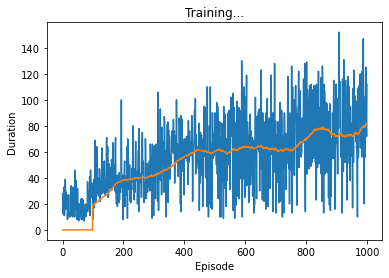

Episode 1000 
 100 episode moving avg: 81.34


In [25]:
# We're now all set up to start training.
# We're going to be storing our episode_durations during training in order to plot them using the plot() 
# function we developed last time, so we create an empty list to store them in.
episode_durations = []

# The first for loop is going to iterate over each episode.
for episode in range(num_episodes):
    
    # For each episode, we first reset the environment, then get the initial state.
    em.reset()
    state = em.get_state()
    
    # we'll step into the nested for loop that will iterate over each time step within each episode.
    for timestep in count():
        
        # For each time step, our agent selects an action based on the current state. Recall, we also need 
        # to pass in the required policy_net since the agent will use this network to select it's action 
        # if it exploits the environment rather than explores it.The agent then takes the chosen action 
        # and receives the associated reward, and we get the next_state.
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        
        # We now can create an Experience using the state, action, next_state, and reward and push 
        # this onto replay memory. After which, we transition to the next state by setting our current state 
        # to next_state.
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        # Now that our agent has had an experience and stored it in replay memory, we'll check to see 
        # if we can get a sample from replay memory to train our policy_net.
        # we can get a sample equal to the batch_size from replay memory as long as 
        # the current size of memory is at least the batch_size.
        if memory.can_provide_sample(batch_size):
            # If we can get a sample from memory, then we get a sample equal to batch_size and 
            # assign this sample to the variable experiences.
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            # We now can calculate the loss between the current_q_values and the target_q_values using 
            # mean squared error mse as our loss function, and then we zero out the gradients using 
            # optimizer.zero_grad().
            # This function sets the gradients of all the weights and biases in the policy_net to zero. 
            # Since PyTorch accumulates the gradients when it does backprop, we need to call zero_grad() 
            # before backprop occurs. Otherwise, if we didn't zero out the gradients each time, then 
            # we'd be accumulating gradients across all backprop runs.
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            
            # We then call loss.backward(), which computes the gradient of the loss with respect to all 
            # the weights and biases in the policy_net.
            loss.backward()
            
            # We now call step() on our optimizer, which updates the weights and biases with the gradients 
            # that were computed when we called backward() on our loss.
            optimizer.step()
            
        # We then check to see if the last action our agent took ended the episode by getting the value of 
        # done from our environment manager em. If the episode ended, then we append the current timestep to 
        # the episode_durations list to store how long this particular episode lasted.
        # We then plot the duration and the 100-period moving average to the screen and break out of the inner 
        # loop so that we can start a new episode.
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
    
    # we have one final check to see if we should do an update to our target_net.
    #  our target_update variable is set to 10, so we check if our current episode is a multiple of 10, 
    # and if it is, then we update the target_net weights with the policy_net weights.
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

# At this point, we can start a new episode. This whole process will end once we've reached the 
# number of episodes set in num_episodes. At that point, we'll close the environment manager.
em.close()